<h1> Project Final Report</h1>
<h3>Group 004_28 </h3>

<h2>Introduction</h2>

<h3>Background</h3>

The Pacific Laboratory for Artificial Intelligence (PLAI) is a research group in computer science at UBC. They have a Minecraft server, PLAIcraft, where they record players' actions as they navigate the virtual world. The research group would like to target their PLAIcraft recruitment efforts and ensure they have enough resources to handle the number of players they attract. 

This report explores the question "*What *kinds* of players are most likely to contribute a large amount of data?*"</br> 
Specifically, our group is interested in learning how a **player's age** might be related to **how much data they contribute** (i.e. total played hours). 

<h3>Summary of Datasets</h3>
The provided data consists of two csv files, 'Players' (9 variables, 196 observations), and 'Sessions' (5 variables, 1535 observations). Both are summarized below.

<h4>Players</h4> 

<div style="display: inline-block">  
    
| Variable         | Type of Data*         | Interpretation | Options / Other Notes|
| ------------------- | --------------------- | -------------------- | ------- |
| *experience*          | categorial - ordinal  | experience level of player, selected by player | *Beginner, Amateur, Regular, Pro, Veteran* |
| *hashedEmail*         | character             | email address of player in hashed form | e.g. *f6daba428a5e19a3d47574858c135*... |
| *name* | character | pseudonym chosen by player | Many options were provided to players. Given this, it makes sense to treat this as character, not factor. |
| *gender* | categorial | gender of player, selected by the player | *Male, Female, Non-binary, Agender, Two-Spirited, Other, Prefer not to say* |
| *played_hours* | double | number of hours player has played on server, to one decimal place | e.g. *22.5* |
| *age* | double | age of player, selected by the player | e.g. *30* |
| *subscribe* | logical | a boolean indicating whether player subscribed to PlaiCraft  updates | *TRUE, FALSE* | 
| *individualId* | double | unique number identifying player | Note that this column contains only *N/A*. |
| *organizationName* | character | organization as indicated by player | Note that this column contains only *N/A*. |
</div>

\* Represents most appropriate type, not the type initially assigned by R.
<br />

<h4>Sessions</h4> 

<div style="display: inline-block"> 
    
| Variable                 | Type of Data* | Interpretation                           | Other Notes |
| ------------------------ | ------------- | ---------------------------------------- | ----------- |
| *hashed_Email*           | character | email address of player in hashed form | e.g. *50499be23603422e6a0ee97...* |
| *start_time*             | character | date, time Plaicraft session began | e.g. *30/06/2024 18:12* |
| *end_time*               | character | date, time  Plaicraft session finished | e.g. *30/06/2024 18:24* |
| *original_start_time*    | double        | UNIX timestamp of session start | e.g. *1.71977E+12* |
| *original_end_time*      | double        | UNIX timestamp of session end | e.g. *1.71977E+12* |

</div>

<h2>Method & Results</h2>

<h3>Loading Data</h3>

First, we load the necessary libraries, then read the datasets from their URLs.

In [46]:
library(tidyverse)
library(tidymodels)
library(repr)

players <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")
sessions <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


<h3>Wrangling & Cleaning Data</h3>

Then, we remove the `individualId` and the `organizationName` columns in the `players` data frame, since all values in these columns are N/A.

In [47]:
players <- players |>
select(-individualId, -organizationName)

Next, we redefine the `experience` and `gender` columns as **factors** using the `as_factor` function, so that these variables will be treated as categorical.

In [48]:
players <- players |>
mutate(experience = as_factor(experience)) |>
mutate(gender = as_factor(gender))

We also create a new `sessions_sum` data frame using `group_by` and `summarise`.
This shows us the number of sessions per hashed email, i.e. the number of sessions per individual.

In [49]:
sessions_sum <- sessions |>
group_by(hashedEmail) |>
summarise(number_of_sessions = n())

head(sessions_sum)

hashedEmail,number_of_sessions
<chr>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,13
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,1


**Table 1. Hashed Email & Number of Sessions**\
(Only the head is displayed for the sake of readability.)

Next, we bind this data frame with the `players` data frame, using `left_join`. This brings together all required variables.  This way, we can use just one data frame for all subsequent analysis steps.

In [50]:
data <- left_join(players, sessions_sum, by = "hashedEmail")

head(data)

experience,subscribe,hashedEmail,played_hours,name,gender,age,number_of_sessions
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA


**Table 2. Dataframe of all player variables**\
(Only the head is displayed for the sake of readability.)

<h3>Summary of Dataset Relevant For Exploratory Data Analysis</h3>

Here we perform a short summary of the data that is relevant for our exploratory data analysis (i.e. `age`), finding the mean, maximum and minimum age values, and standard deviation.

In [54]:
summary <- data |> summarize(mean = mean(age), max = max(age), min = min(age), standard_deviation = sd(age))

summary 

mean,max,min,standard_deviation
<dbl>,<dbl>,<dbl>,<dbl>
21.28061,99,8,9.706346


In [21]:
<h3>Data Analysis 1 - Linear Regression</h3>

We start our data analysis by setting the seed. Then we split the data into training and testing sets, in a 70:30 ratio.

In [ ]:
set.seed(2000) 

data_split <- initial_split(data, prop = 0.7, strata = age)
data_training <- training(data_split)
data_testing <- testing(data_split)

Before creating a model, we make a **scatterplot** using `ggplot`, to see if there seems to be a relationship between the `age` and `played_hours` variables.

**<h4>Figure 1. Total Playtime vs. Age**

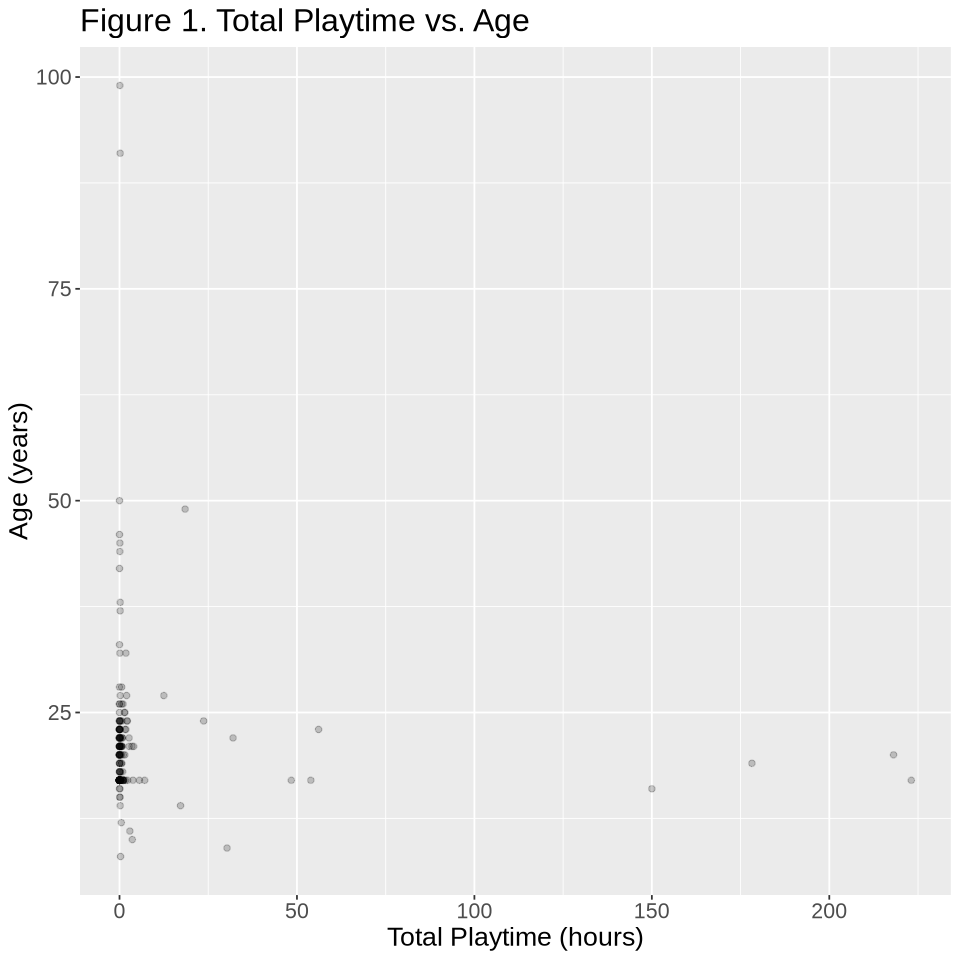

In [35]:
options(repr.plot.width = 8, repr.plot.height = 8)

age_playtime <- data |>
ggplot(aes(x = played_hours, y = age)) +
geom_point(alpha = 0.2) +
labs(x = "Total Playtime (hours)", y = "Age (years)") +
ggtitle("Figure 1. Total Playtime vs. Age") +
theme(text = element_text(size = 16))

age_playtime

From this figure, we can conclude that the dataset includes mostly players who are young (< 25 years) and play very few hours. Among the players that *do* play many hours (e.g. more than 25 hours), most of them are young (< 25 years).

From Figure 1, the relationship between `age` and `played_hours` is not especially clear, but perhaps it could be weakly negative and linear. There seem to be a few outliers (e.g. an individual who has played nearly 250 hours) and a lot of zero-hour plays.

We would like to further explore the relationship between `age` and `played_hours`. Since both variables are numeric, and we see a slight indication of a linear relationship, we'll try a **linear regression**. Since we would like to know the characteristics of players that contribute a large amount of data, we will create a model that predicts `age` using `played_hours`. If our model is accurate-- in other words, if the $RMSE$ and $RMSPE$ are low enough-- we will conclude that player's *age* can help us to predict their *played hours*.

In this step, we will:

- create a linear regression model specification, named `lm_spec`
- create a recipe for `lm_spec`, named `data_recipe`
- fit the model specification and recipe in a workflow, named `data_fit`

In [23]:
lm_spec <- linear_reg() |> 
       set_engine("lm") |>
       set_mode("regression")

data_recipe <- recipe(age ~ played_hours, data = data_training)

data_fit <- workflow() |>
       add_recipe(data_recipe) |>
       add_model(lm_spec) |>
       fit(data = data_training)

data_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)  played_hours  
    21.69401      -0.02578  


<br>
The equation of the line indicates that when played_hours is 0, the predicated age is 22. From the y-intercept (age) of 22, the average player's age decreases, at the rate of 0.02578 years per hour of playtime.

<br>
<br>
Next, we will calculate the $RMSE$ to assess the goodness of fit on `data_fit`.

Note that this is going to tell us how well the model predicts the **training data** used to fit the model.

In [24]:
lm_rmse <- data_fit |>
         predict(data_training) |>
         bind_cols(data_training) |>
         metrics(truth = age, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lm_rmse

[1] 11.02085

The $RMSE$ of 11.02 tells us that the training data points on the scatterplot were off by an average distance of 11.02 years from the line of best fit.

We calculate the $RMSPE$ by completing the same process on the **testing data**.

In [25]:
lm_rmspe <- data_fit |>
         predict(data_testing) |>
         bind_cols(data_testing) |>
         metrics(truth = age, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lm_rmspe

[1] 5.783111

The $RMSPE$ of 5.78 tells us that the training data points on the scatterplot were off by an average distance of 5.78 years from the line of best fit.

Especially considering the dataset mostly consists of players < 30 years, a 5.78 difference in predicted age is substantial. Using `played_hours` as a predictor does not result in a particularily accurate prediction.

The outliers mentioned earlier (i.e. points of astonishingly high play times and points of surprisingly advanced age) may contribue to this. We identify them, by ordering the data frame in **descending order** for each variable, using the `arrange` function.

**<h4>Table 2. All Players, in descending order of `age`**

In [26]:
data_age_desc <- arrange(data, desc(age))
head(data_age_desc)

experience,subscribe,hashedEmail,played_hours,name,gender,age,number_of_sessions
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>
Regular,TRUE,7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d,0.1,Devin,Two-Spirited,99,1
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,1
Regular,FALSE,7b17513f11968feaf6b02977885c436dc2a4549489ca25ef03022f9fbae19d81,0.0,Balthazar,Male,50,1
Regular,TRUE,c57fa94e436cf49a929d0168e47d26fec3d900b321775e280ef136979c01d5a4,18.5,Dante,Male,49,16
Veteran,FALSE,4c0662a559f9d83b4d84ce3d86e6577c9f7a426c80465c6174321afd96664da5,0.0,Selena,Male,46,NA
Amateur,FALSE,6fa105fac7f4f37350f21830db78cde153d8edda41d6f4f2d48c9785d605c5e5,0.1,Yosef,Male,45,1


(Only the head is displayed for the sake of readability.)

**<h4>Table 3. All Players, in descending order of `played_hours`</h4>**

In [27]:
data_playtime_desc <- arrange(data, desc(played_hours))
head(data_playtime_desc)

experience,subscribe,hashedEmail,played_hours,name,gender,age,number_of_sessions
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>
Regular,TRUE,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,223.1,Hiroshi,Male,17,219
Regular,TRUE,b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,218.1,Akio,Non-binary,20,95
Regular,TRUE,ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,178.2,Piper,Female,19,147
Amateur,TRUE,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,150.0,Delara,Female,16,159
Amateur,TRUE,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,56.1,Dana,Male,23,310
Amateur,TRUE,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,53.9,Alex,Male,17,130


(Only the head is displayed for the sake of readability.)

We can see that players **Devin, Ahmed, Hiroshi, Akio, Piper and Delara** have either:
(1) playtimes that are orders of magnitude higher than most of the players, or 
(2) a very advanced age, compared to most other players. 

We suspect outliers of type (1) could represent e.g. research team members themselves, testing the environment. We only want to include participant player data. We suspect outliers of type (2) may be caused by players entering an inaccurate age. These outliers may be affecting our model's accuracy.

We also debated removing zero-contribution players. However, we conclude they represent legitimate cases (e.g. subscribers who haven’t played), so conclude they are relevant to the analysis.

We delete types (1) and (2) from the data frame using the `filter` function.

In [28]:
outliers <- c("Devin", "Ahmed", "Hiroshi", "Akio", "Piper", "Delara")

ref_data <- filter(data, !name %in% outliers)
head(ref_data)

experience,subscribe,hashedEmail,played_hours,name,gender,age,number_of_sessions
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA


**Table 4. Dataframe of all player data, with outliers removed**

Using this refined data frame, we will now repeat the entire process (except creating the recipe, since that is identical) and calculate its $RMSE$ and $RMSPE$.

In [29]:
set.seed(1999)

ref_data_split <- initial_split(ref_data, prop = 0.7, strata = age)
ref_data_training <- training(ref_data_split)
ref_data_testing <- testing(ref_data_split)

ref_data_recipe <- recipe(age ~ played_hours, data = ref_data_training)

ref_data_fit <- workflow() |>
       add_recipe(ref_data_recipe) |>
       add_model(lm_spec) |>
       fit(data = ref_data_training)

ref_data_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)  played_hours  
     20.9246        0.0237  


In [30]:
ref_lm_rmse <- ref_data_fit |>
         predict(ref_data_training) |>
         bind_cols(ref_data_training) |>
         metrics(truth = age, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

ref_lm_rmse

[1] 6.499313

In [31]:
ref_lm_rmspe <- ref_data_fit |>
         predict(ref_data_testing) |>
         bind_cols(ref_data_testing) |>
         metrics(truth = age, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

ref_lm_rmspe

[1] 5.547639

The calculated $RMSE$ and $RMSPE$ values are both lower than their values calculated when including the outliers. The $RMSPE$ value of 5.55 is slightly more accurate than the earlier $RMPSE$ of 5.78. 

Using either model (outliers in, or outliers out), `playtime` appears to be an okay predictor of `age`, but not especially great. There may be other variables that are better predictors.

It could also be the case that the relationship between `age` and `played_hours` is non-linear! In our next analysis, we will explore this possibility.
<br>

<h3>Data Analysis 2 - KNN Regression</h3>

Instead of a linear regression, another approach we can take is building a knn-regression model. Re-examining figure 1, the relationship doesn't look especially linear-- the characterics of our data may make a non-linear model a better fit. 

We can perform knn regression to predict `age` based on total `played_hours`. 

First, we’ll need to perform 5-fold cross validation on the training dataset to test for the optimal k. 

In [32]:
data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("regression")

data_recipe <- recipe(age ~ played_hours, data = data_training) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())

data_vfold <- vfold_cv(data, v = 5, strata = age)

data_workflow <- workflow() |>
                     add_recipe(data_recipe) |>
                     add_model(data_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

data_results <- data_workflow |>
                        tune_grid(resamples = data_vfold, grid = gridvals) |>
                        collect_metrics()
head(data_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,10.724146948,5,1.265286978,Preprocessor1_Model01
1,rsq,standard,0.006508304,5,0.003482294,Preprocessor1_Model01
2,rmse,standard,10.096164773,5,1.380320689,Preprocessor1_Model02
2,rsq,standard,0.007579657,5,0.003091119,Preprocessor1_Model02
3,rmse,standard,10.093215769,5,1.209158905,Preprocessor1_Model03
3,rsq,standard,0.014674434,5,0.007500308,Preprocessor1_Model03


The optimal k will have the lowest $RMSE$ value. Thus, we look for the k value that results in the **minimum rmse**. 

In [33]:
data_min <- data_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)

k_min <- data_min |>
            pull(neighbors)

Now, we can use this k value to train our final model. 

In [34]:
data_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
                            set_engine("kknn") |>
                            set_mode("regression")

data_best_fit <- workflow() |>
                        add_recipe(data_recipe) |>
                        add_model(data_best_spec) |>
                        fit(data = data_training)

Next, we use metrics function to evaluate the effectiveness of the model

In [27]:
data_summary <- data_best_fit |> 
                       predict(data_testing) |>
                       bind_cols(data_testing) |>
                       metrics(truth = age, estimate = .pred)
data_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6.39929432
rsq,standard,0.03948757
mae,standard,3.68387097


The $RMSE$ is approximately 6.40. This means the average difference between a data point and our line of best fit is 6.40 years. 

Similar to the linear model, this model's predications of `age` based on `played_hours` are not as accurate as we might hope.

<h2>Discussion</h2> 

#### Summary ####

In our exploratory data analysis, we plotted `age` vs `played_hours` (Figure 1). Based on this exploratory analysis, we predicted a linear relationship between the age of the player and the total number of hours played. We created a linear regression model, where the predictor variable was the total number of hours played (`played_hours`) and the predicted variable was the age of the player (`age`). 

To test the performance of the model, we used the training model to predict age from the test data, and calculated the $RMSPE$. The model had an $RMSPE$ of 5.36. Our analysis shows there is a weakly negative linear relationship between age and total played hours. Looking back Figure 1, we see that players younger than ~25 years are contributing the most playtime. 

When a linear model didn't return a particularily excellent RMSPE, we took a closer look at the exploratory plot, and realized the relationship might not be linear. We then created a knn regression model, which had an RMPSE of 5.78.

#### Expectations ####

Our results partially aligned with our expectations.

Our linear regression indicated that there exists some relationship between age and total play time, which we expected. Given that the linear relationship appeared weak in the exploratory analysis, we did not have expectations of a particularly well-fitting model or low RMSPE. 

We had concerns about the size of dataset from early on in the project, especially given that a large proportion (82/196) players contributed 0 hours of playtime. A dataset with more representation across a range of played_hours would give us stronger predictive ability! The relationship we observed is likely driven by these 0 hour points, resulting in model slopes that are close to flat, and washing out any other trends we might see.

Additionally, in both analyses, we used only a single predicting variable. Our model was overly simple, and likely did not handle nuances in the data (e.g. perhaps younger players play more, generally, but this is driven by younger players who are amateur or regular in experience level). We could be strenthened by adding a greater number of predictors, assuming these added predictors have predictive power.

Our results also connect to our expectations based on our day-to-day experiences. We’d expect young adults might be most likely to engage in video games (such as PLAICraft) compared to other age groups. 

#### Potential impact #### 

Understanding demographic details of those who contribute the most playtime can help in targeted recruitment and marketing efforts. 

In this case, since we believe younger players (under 25) might contribute the most playtime, the research team can focus efforts on this demographic. For example, the researchers could advertise their study in locations that young adults frequent (e.g. high schools, universities, colleges, relevant subreddits, social media etc.). 

The researchers could also focus their development to enhance engagement for younger players. For example, this demographic might find social or competitive elements particularily appealing.

#### Future questions #### 

Our findings point us to several area of future work:

* Can we use played_hours to more accurately predict other demographic characteristics of players?

We suspect it could be interesting to explore subscription status and it's relationship with played hours. From exploratory visualizations in our individual projects, we saw that almost all players with a high level of played_hours subscribe to Plaicraft email updates. Future work could use subscription status to predict number of played hours.

* We could explore the use of played_hours as a predictor of subscription status. 